In [1]:
import os
import pickle
import re
import sys
from glob import glob

import climate_envs
import climlab
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"
NUM_STEPS = 500

sys.path.append(BASE_DIR)

In [3]:
fp = f"{DATASETS_DIR}/air.mon.ltm.1981-2010.nc"

if not os.path.exists(fp):
    print("Downloading NCEP air data ...")
    ncep_url = (
        "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/"
    )
    ncep_air = xr.open_dataset(
        ncep_url + "pressure/air.mon.1981-2010.ltm.nc#mode=bytes",
        use_cftime=True,
    )
    ncep_air.to_netcdf(fp)
else:
    print("Loading NCEP air data ...")
    ncep_air = xr.open_dataset(fp, use_cftime=True)

coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")
Tobs = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))

Loading NCEP air data ...


/tmp/ipykernel_3743122/223733448.py:15: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ncep_air = xr.open_dataset(fp, use_cftime=True)


In [4]:
rce_state = climlab.column_state(lev=Tobs.level[1:], water_depth=2.5)

h2o = climlab.radiation.ManabeWaterVapor(state=rce_state, lev=Tobs.level[1:])

rad = climlab.radiation.RRTMG(
    name="Radiation (net)",
    state=rce_state,
    specific_humidity=h2o.q,
    S0=1365.0,
    timestep=climlab.constants.seconds_per_day,
    albedo=0.25,
)

conv = climlab.convection.ConvectiveAdjustment(
    name="Convection",
    state=rce_state,
    adj_lapse_rate="MALR",
    timestep=rad.timestep,
)

climlab_rcm = climlab.couple([h2o, rad, conv], name="RCE Model")
climlab_rcm.state.Tatm[:] = climlab_rcm.state.Ts


def get_rcm_temp_CtoK(climlab_rcm):
    rcm_temp = np.concatenate(
        [climlab_rcm.Tatm, climlab_rcm.Ts], dtype=np.float32
    )
    rcm_temp -= climlab.constants.tempCtoK
    rcm_temp = xr.DataArray(
        rcm_temp, coords={"level": Tobs.level.values[::-1]}
    )
    return rcm_temp.values


climlab_rcm_temps = [get_rcm_temp_CtoK(climlab_rcm)]
for n in range(NUM_STEPS):
    climlab_rcm.step_forward()
    climlab_rcm_temp = get_rcm_temp_CtoK(climlab_rcm)
    climlab_rcm_temps.append(climlab_rcm_temp)

climlab_rcm_temps = np.array(climlab_rcm_temps)

In [5]:
def extract_algo(dirname):
    match = re.search(r"inference_([a-z0-9]+)_torch", dirname)
    return match.group(1) if match else None


def get_record_fns(exp_id):
    record_fns = glob(f"{RECORDS_DIR}/inf*{exp_id}_*/*/*_{NUM_STEPS}.pth")
    record_fns = [
        fn
        for fn in record_fns
        if extract_algo(os.path.basename(os.path.dirname(fn))) in ALGOS
    ]
    return record_fns

In [6]:
from multiprocessing import Pool, cpu_count


def make_env(env_id):
    def thunk():
        env = gym.make(env_id)
        return env

    return thunk


def recover_states(env_id, seed, actions):
    envs = gym.vector.SyncVectorEnv([make_env(env_id)])
    envs.reset(seed=seed)
    states = []

    for i in range(actions.shape[0]):
        next_obs = envs.step(np.expand_dims(actions[i], 0))[0]
        states.append(next_obs)

    states = np.array(states).squeeze()
    return states


def get_action_row(record_fn):
    with open(record_fn, "rb") as f:
        env_id = record_fn.split("/")[-2].split("__")[0]
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        if algo in ["ppo", "trpo"]:  # due to env clipping observations
            rce_RL_state = recover_states(
                env_id, seed, record_steps["actions"]
            )
        else:
            rce_RL_state = record_steps["next_obs"]
        rce_RL_state = np.concatenate((climlab_rcm_temps[0:1], rce_RL_state))

        Tprofile_RL = xr.DataArray(
            rce_RL_state[-1], coords={"level": Tobs.level.values[::-1]}
        )
        error = Tobs.sel(level=[100, 200, 1000]) - Tprofile_RL.sel(
            level=[100, 200, 1000]
        )

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "error": error,
            "state": rce_RL_state,
            "actions": record_steps["actions"],
            "fn": record_fn,
        }


def get_action_rows(record_fns):
    with Pool(processes=cpu_count() - 2) as pool:
        results = list(
            tqdm.tqdm(
                pool.imap_unordered(get_action_row, record_fns),
                total=len(record_fns),
            )
        )
    return [row for row in results if row is not None]

In [7]:
EXPERIMENT_ID = "rce17-v0-optim-L-10k"
ALGOS = {"tqc", "ddpg", "dpg"}

record_fns = get_record_fns(EXPERIMENT_ID)

df = pd.DataFrame(get_action_rows(record_fns))
df["error_mse"] = df["error"].apply(lambda x: np.mean(np.square(x.values)))
df.drop(columns=["error", "state", "actions"], inplace=True)
df = df.sort_values("error_mse", ascending=True)
df.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 264.15it/s]


,exp_id,algo,seed,fn,error_mse
26,rce17-v0-optim-L-10k,tqc,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.919664
0,rce17-v0-optim-L-10k,ddpg,2,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
25,rce17-v0-optim-L-10k,dpg,10,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
24,rce17-v0-optim-L-10k,dpg,7,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
21,rce17-v0-optim-L-10k,dpg,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
19,rce17-v0-optim-L-10k,dpg,3,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
17,rce17-v0-optim-L-10k,dpg,2,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
15,rce17-v0-optim-L-10k,ddpg,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
13,rce17-v0-optim-L-10k,ddpg,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583
12,rce17-v0-optim-L-10k,dpg,8,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583


In [8]:
from base64 import b64encode

from IPython.display import HTML

video_path = (
    df.values[0][3]
    .replace("/records/", "/videos/")
    .replace(f"step_{NUM_STEPS}.pth", "rl-video-episode-0.mp4")
)
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    f"""
<video width=1280 controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""
)

In [9]:
from collections import defaultdict


def get_records(record_fns):
    records = defaultdict(dict)
    for record_fn in record_fns:
        action_row = get_action_row(record_fn)
        algo = action_row["algo"].lower()
        seed = int(action_row["seed"])
        state = action_row["state"]
        actions = action_row["actions"]
        records[algo][seed] = {"state": state, "actions": actions}
    return records

In [10]:
def plot_RCE_state_action(records, algo, exp_id, pressure_hPa=1000):
    level_arr = np.array(Tobs.level.values)[::-1]
    level_idx = np.abs(level_arr - pressure_hPa).argmin()
    true_pressure = level_arr[level_idx]

    observed_value = float(Tobs.sel(level=true_pressure).mean())

    all_states = [
        records[algo][s]["state"][:-1, level_idx] for s in records[algo]
    ]
    all_states = np.stack(all_states)
    state_mean = all_states.mean(axis=0)
    state_std = all_states.std(axis=0)

    climlab_state = climlab_rcm_temps[:-2, level_idx]
    timesteps = np.arange(len(records[algo][1]["actions"]))

    all_emissivity = [records[algo][s]["actions"][:, 0] for s in records[algo]]
    all_lapse = [
        records[algo][s]["actions"][:, 1 + level_idx] for s in records[algo]
    ]

    all_emissivity = np.stack(all_emissivity)
    all_lapse = np.stack(all_lapse)

    e_min, e_max = 0, 1
    l_min, l_max = 5.5, 9.8
    q_min, q_max = 0, 5

    def normalise(x, min_val, max_val):
        return (x - min_val) / (max_val - min_val)

    emiss_mean = all_emissivity.mean(axis=0)
    emiss_std = all_emissivity.std(axis=0)
    lapse_mean = all_lapse.mean(axis=0)
    lapse_std = all_lapse.std(axis=0)

    emiss_mean_n = normalise(emiss_mean, e_min, e_max)
    emiss_std_n = emiss_std / (e_max - e_min)
    lapse_mean_n = normalise(lapse_mean, l_min, l_max)
    lapse_std_n = lapse_std / (l_max - l_min)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

    ax1.plot(timesteps, state_mean, label="RCE Model w/ RL", color="black")
    ax1.fill_between(
        timesteps,
        state_mean - state_std,
        state_mean + state_std,
        color="black",
        alpha=0.2,
    )
    ax1.plot(
        timesteps,
        climlab_state,
        label="RCE Model",
        color="black",
        linestyle="--",
    )
    ax1.axhline(observed_value, label="Observed", color="red", linestyle="--")
    ax1.set_ylabel("Temperature (°C)")
    ax1.set_title(f"{algo.upper()} | {int(true_pressure)} hPa")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(
        timesteps, emiss_mean_n, label="Surface Emissivity", color="tab:blue"
    )
    ax2.fill_between(
        timesteps,
        emiss_mean_n - emiss_std_n,
        emiss_mean_n + emiss_std_n,
        color="tab:blue",
        alpha=0.3,
    )

    ax2.plot(timesteps, lapse_mean_n, label="Lapse Rate", color="tab:orange")
    ax2.fill_between(
        timesteps,
        lapse_mean_n - lapse_std_n,
        lapse_mean_n + lapse_std_n,
        color="tab:orange",
        alpha=0.3,
    )

    ax2.set_ylabel("Normalised [0–1]")
    ax2.set_xlabel("Timestep")
    ax2.set_ylim(-0.25, 1.25)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(
        f"{IMGS_DIR}/{exp_id}_{algo}_{int(true_pressure)}hPa_TEL.png", dpi=300
    )

In [11]:
records = get_records(record_fns)

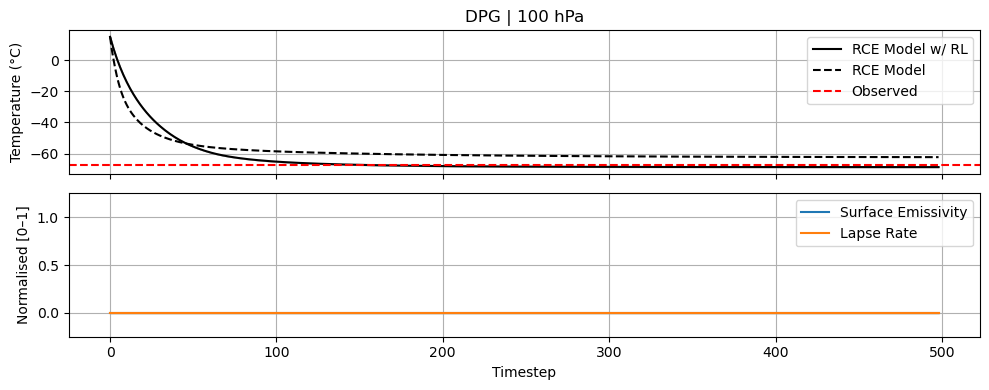

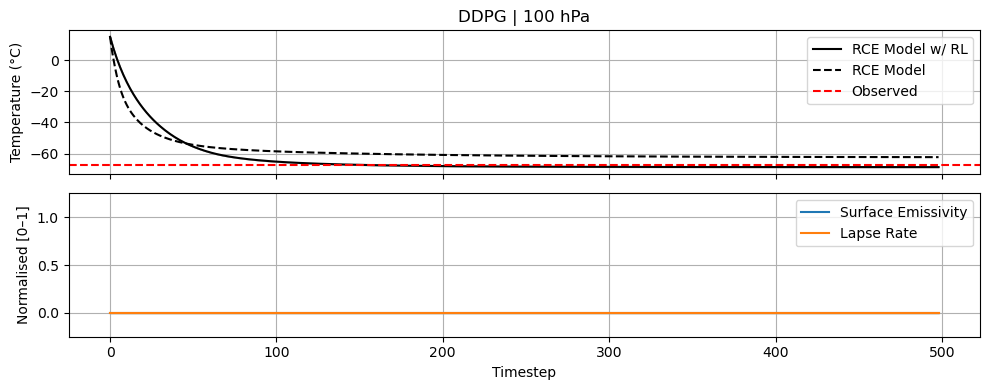

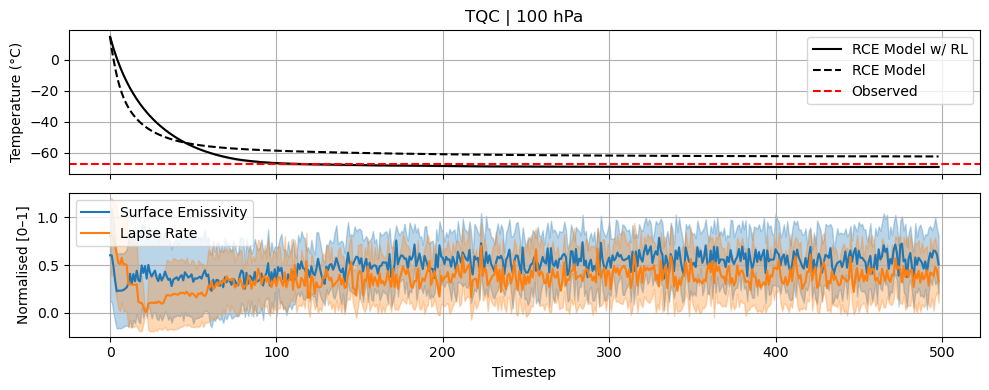

In [12]:
pressure_hPa = 100

for algo in ALGOS:
    plot_RCE_state_action(records, algo, EXPERIMENT_ID, pressure_hPa)

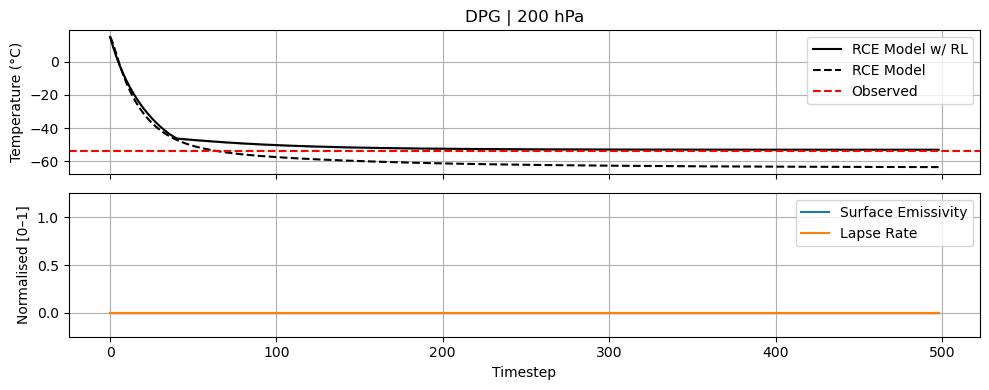

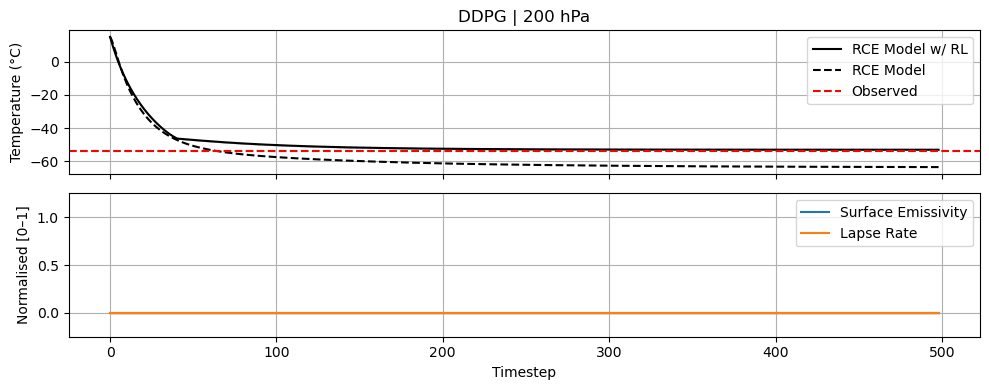

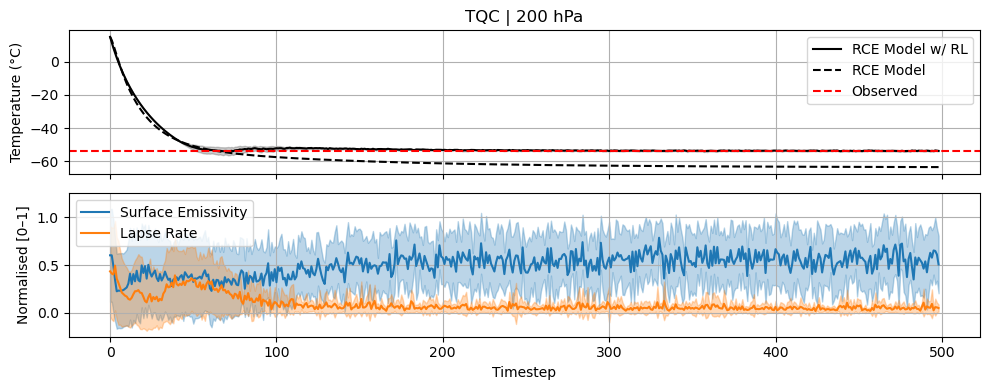

In [13]:
pressure_hPa = 200

for algo in ALGOS:
    plot_RCE_state_action(records, algo, EXPERIMENT_ID, pressure_hPa)

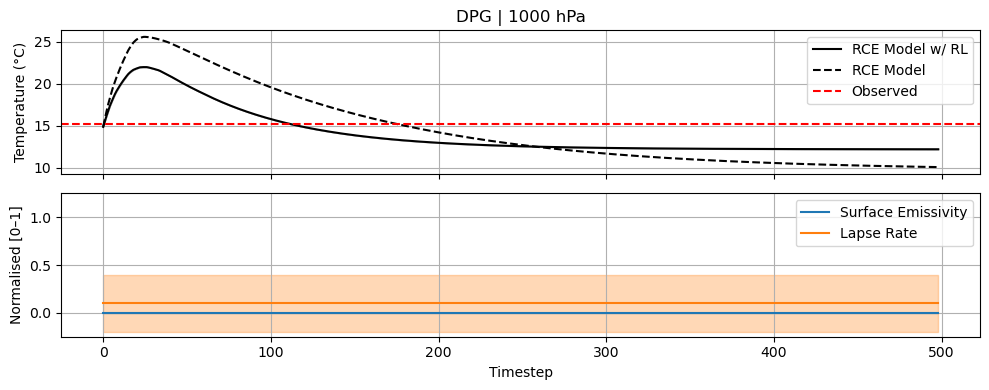

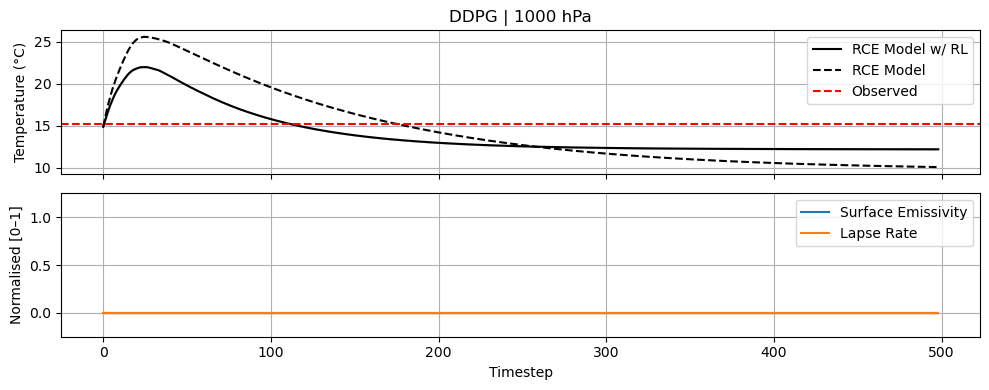

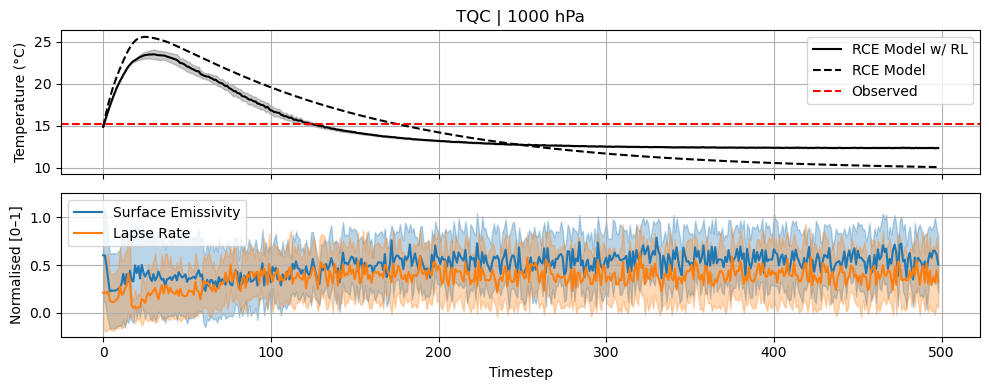

In [14]:
pressure_hPa = 1000

for algo in ALGOS:
    plot_RCE_state_action(records, algo, EXPERIMENT_ID, pressure_hPa)